In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1

## a)

In [5]:
# copied from list 3

def sq_dists(x, y):
    """x, y: 2d arrays of row vectors,
    returns squared distances between each vector in x and y
    """
    d = x[:, np.newaxis, :] - y[np.newaxis, :, :]
    return (d ** 2).sum(axis=-1)  # no sqrt for performance

In [6]:
import scipy.stats

class KNN:
    """K Nearest Neighbors implementation"""
    _labels = None
    
    def __init__(self, k, train_data, train_target):
        self.k = k
        self.train_data = train_data
        self.train_target = train_target
    
    def fit(self, data):
        dists = sq_dists(self.train_data, data)
        nearest_indices = np.argpartition(dists, self.k, axis=0)[:self.k]
        nearest_targets = self.train_target[nearest_indices]
        self._labels = scipy.stats.mode(nearest_targets)[0][0]
    
    @property
    def labels(self):
        if self._labels is None:
            raise RuntimeError("Classifier not fit")
        return self._labels

## b)

Test on Iris dataset

In [7]:
from sklearn import datasets

iris = datasets.load_iris()

In [8]:
def _plot_iris_knn(train_data, train_target, test_data, test_target, labels):
    """Only first two features"""
    _, ax = plt.subplots(1, 1, figsize=(12, 8))
    colors = 'myc'
    # plot training data
    for i, (tname, color) in enumerate(zip(iris.target_names, colors)):
        samples = train_data[train_target == i]
        ax.scatter(samples[:, 0], samples[:, 1], s=20, label=tname, c=color, alpha=0.5)
    # plot wrongly classified test samples
    samples = test_data[test_target != labels]
    ax.scatter(samples[:, 0], samples[:, 1], s=200, marker='X', c='r')
    # plot test data with classification
    for i, color in enumerate(colors):
        samples = test_data[labels == i]
        ax.scatter(samples[:, 0], samples[:, 1], s=50, c=color, edgecolors='k')
    ax.set_xlabel(iris.feature_names[0])
    ax.set_ylabel(iris.feature_names[1])
    ax.legend()

def test_knn_on_iris(k, *, plot=False):
    perm = np.random.permutation(150)
    train_data, test_data = np.split(iris.data[perm], [100])
    train_target, test_target = np.split(iris.target[perm], [100])

    knn = KNN(k, train_data, train_target)
    knn.fit(test_data)

    if plot:
        _plot_iris_knn(train_data, train_target, test_data, test_target, knn.labels)

    err = np.sum(knn.labels != test_target)
    return err / len(test_target)

0.02

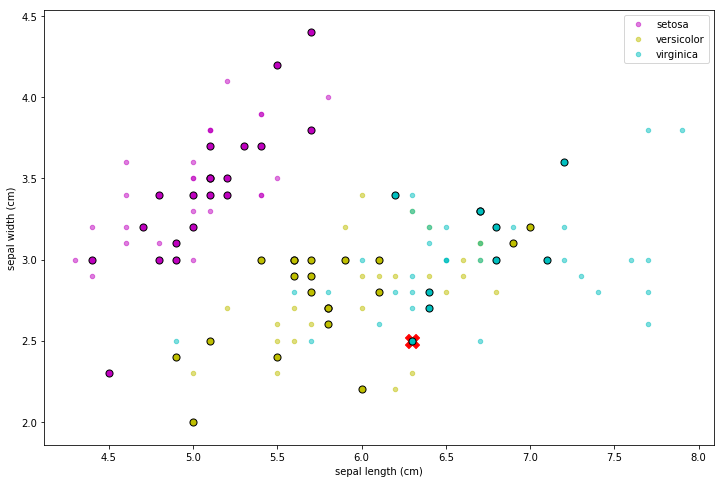

In [9]:
test_knn_on_iris(3, plot=True)

0.04

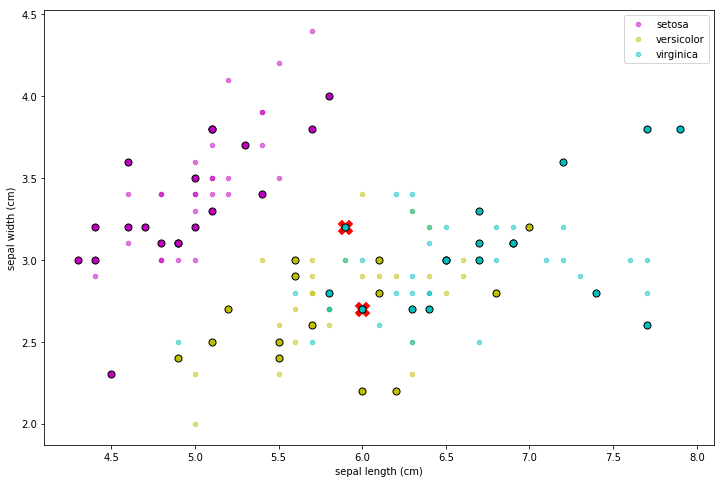

In [10]:
test_knn_on_iris(5, plot=True)

In [11]:
for k in 3, 5, 10, 20:
    errs_ratio = [test_knn_on_iris(k) for _ in range(10)]
    print(k, np.mean(errs_ratio))

3 0.033999999999999996
5 0.030000000000000006
10 0.041999999999999996
20 0.046


## c)

Test on Optdigits dataset

In [12]:
optdigits_train = pd.read_csv('assets/optdigits.tra', header=None)
optdigits_test = pd.read_csv('assets/optdigits.tes', header=None)

optdigits_train_data = optdigits_train.drop(64, axis=1).values
optdigits_train_target = optdigits_train[64].values
optdigits_test_data = optdigits_test.drop(64, axis=1).values
optdigits_test_target = optdigits_test[64].values

In [28]:
def _plot_failed_samples(samples, labels, target):
    count = min(len(samples), 10)
    _, axes = plt.subplots(1, count, figsize=(10, 1))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i].reshape(8, 8))
        ax.set_title(f'{labels[i]} ({target[i]})')

In [29]:
def test_knn_on_optdigits(k, *, plot=False):
    knn = KNN(k, optdigits_train_data, optdigits_train_target)
    knn.fit(optdigits_test_data)
    
    failed_mask = knn.labels != optdigits_test_target
    if plot:
        _plot_failed_samples(
            optdigits_test_data[failed_mask],
            knn.labels[failed_mask],
            optdigits_test_target[failed_mask],
        )
    
    err = np.sum(failed_mask)
    return err / len(optdigits_test_target)

0.021702838063439065

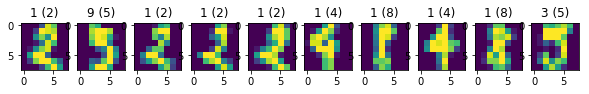

In [30]:
test_knn_on_optdigits(3, plot=True)

## d)

Cross-validation testing

In [12]:
def cross_validate_knn(k, data, target):
    perm = np.random.permutation(len(target))
    data_ = data[perm]
    target_ = target[perm]
    
    data_batches = np.array_split(data_, 10)
    target_batches = np.array_split(target_, 10)
    
    err_ratios = []
    for i in range(10):
        train_data = np.vstack([*data_batches[:i], *data_batches[i + 1:]])
        train_target = np.hstack([*target_batches[:i], *target_batches[i + 1:]])
        test_data = data_batches[i]
        test_target = target_batches[i]
        
        knn = KNN(k, train_data, train_target)
        knn.fit(test_data)
        
        err = np.sum(knn.labels != test_target)
        err_ratios.append(err / len(test_target))
        
    return np.sum(err_ratios)

In [13]:
datasets = {
    'Iris': (iris.data, iris.target),
    'Optdigits': (optdigits_train_data, optdigits_train_target),
}

for name, (data, target) in datasets.items():
    print(name)
    for k in 3, 5, 10:
        err_ratio = cross_validate_knn(k, data, target)
        print(k, err_ratio)

Iris
3 0.33333333333333337
5 0.39999999999999997
10 0.39999999999999997
Optdigits
3 0.1333848235889164
5 0.15168892594972183
10 0.17004770822796056
